# Can We Predict Whether Someone Survived The Titanic Sinking?

The sinking of the Titanic is one the most well known events in human history. Boasting both pop-culture significance and historical relevance there are likely thousands if not millions of people who have asked the question; "Would I survive the Titanic?" While we have no way to go back in time and see for ourselves we thankfully have the second best thing: data. More specifically data on the passengers. We know who they were, where they stayed and most importantly if they survived. Let's take a look at this historical demographic battle royale and see what kind of person was most likely to survive the Titanic.

In [426]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

Before we start to do any actual analysis it is a good idea to get a grasp on the data we have.

In [427]:
train_data = pd.read_csv('train.csv')
train_data.head()
print(train_data.to_string())

     PassengerId  Survived  Pclass                                                                                Name     Sex    Age  SibSp  Parch              Ticket      Fare            Cabin Embarked
0              1         0       3                                                             Braund, Mr. Owen Harris    male  22.00      1      0           A/5 21171    7.2500              NaN        S
1              2         1       1                                 Cumings, Mrs. John Bradley (Florence Briggs Thayer)  female  38.00      1      0            PC 17599   71.2833              C85        C
2              3         1       3                                                              Heikkinen, Miss. Laina  female  26.00      0      0    STON/O2. 3101282    7.9250              NaN        S
3              4         1       1                                        Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.00      1      0              113803   53.1000       

There are 12 categories provided to us. It is a good idea to write down exactly what they each represent.

PassengerId - ID of the Passenger

Pclass - The ticket class the passenger has. The quality goes best to worst 1, 2, 3

Name - The name of the Passenger

Sex - The sex of the passenger Male or Female

Age - The age of the Passenger

SibSp - The number of Siblings or Spouses the Passenger had on board

Parch = The number of Parents or Children the Passenger had on board

Ticket -  The Ticket Number of the Passenger

Fare - The Price paif for the ticket

Cabin - The Cabin they resided in

Embarked - The Port from which they embarked C = Cherbourg, Q = Queenstown, S = Southampton

The Standout Category is Survived

Survived - Whether or not they survived. 1 for Yes, 0 for No.

Our entire model will be built around predicting whether a Passenger gets a 1 or a zero.

Now that we understand the data lets try to clean it up. First lets get rid of any non-essential categories. The column  "PassengerID" stands out as not particullarly useful as it only serves as a sort of built in index for each passenger. Therefore it should be deleted. Next is 'Name'. In a vacuum, name is actually quite useful as the titles Mr, Miss, and Mrs would allow us to determine whether the passenger was Male or Female and if they were a Female if they had children. However we already have categories for all of those factors which means 'Name' serves no purpose to use.

In [428]:
train_data = train_data.drop('PassengerId', axis=1)
train_data = train_data.drop('Name', axis=1)


Now that obvious irrelevncies have be cleared its time to look closer at the values that in the data frame to see if we can actually use them. A category may be relevant but have so many Null variables that it doesn't have any practical use from a model creating standpoint. 

In [429]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    891 non-null    object 
 7   Fare      891 non-null    float64
 8   Cabin     204 non-null    object 
 9   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 69.7+ KB
None


From the look of things the category with the most Null elements is cabin. Now the cabin by itself is a highly relevant part of a person's chances of survival. Each cabin Value is separated into a letter and a number. While the number is not particularly significant, the letter is very important as it tells us the floor the person was living on. A person living on A near the upper decks and lifeboats has a much higher chance to survive than someone on G who has to traverse 6 floors to make it to the boat. However due to the fact that over 3/4ths of the data is missing, the potential for this category to inaccurately skew the data is too high so it has to be removed.

The other category with a lot of nulls is Age. However, considering that 80% of the data is intact and usable the ratio of survivors to dead should be accurately reflected in this category and thus it stays.

In [430]:
train_data = train_data.drop('Cabin', axis=1)

Now that the data is clean we can see the correlations between each remaining category and whether the person survived. We will first do Qualitative Data then move on to Quantitaive data.

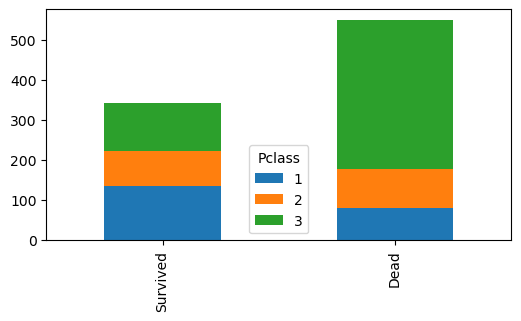

In [431]:
survived = train_data[train_data['Survived']==1]['Pclass'].value_counts()
survived = survived.sort_index()
dead = train_data[train_data['Survived']==0]['Pclass'].value_counts()
dead = dead.sort_index()
df = pd.DataFrame([survived,dead])
df.index = ['Survived','Dead']
bar = df.plot(kind='bar',stacked=True, figsize=(6,3))

Class has an obvious effect on survival rate as passengers of a higher class have a larger proportion of surviving passengers.


<Axes: >

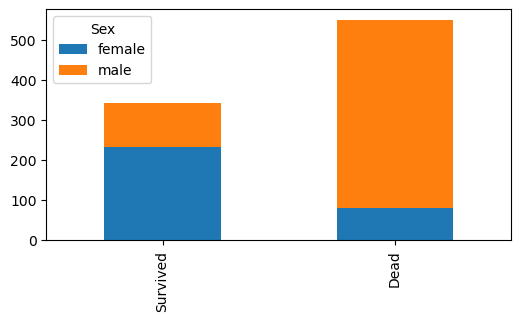

In [432]:
survived = train_data[train_data['Survived']==1]['Sex'].value_counts()
dead = train_data[train_data['Survived']==0]['Sex'].value_counts()
df = pd.DataFrame([survived,dead])
df.index = ['Survived','Dead']
df.plot(kind='bar',stacked=True, figsize=(6,3))

Sex has a very clear impact on survival rate as the proportion of 'female' passengers who survived is much higher than 'male' passengers.

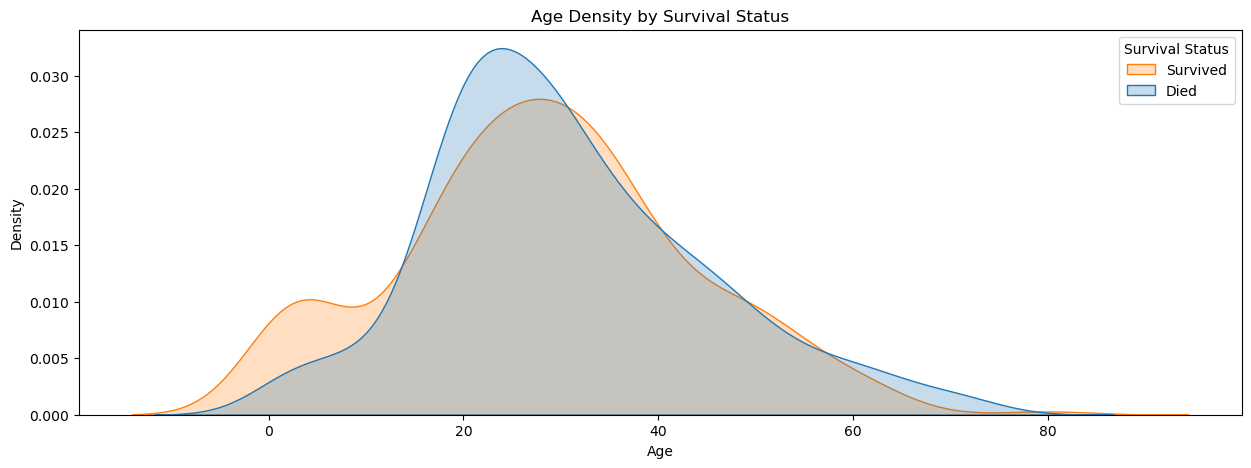

In [433]:
df = pd.DataFrame({'Age':train_data['Age'],'Survival':train_data['Survived']})

plt.figure(figsize=(15, 5))
sns.kdeplot(data=df, x='Age', hue='Survival', common_norm=False, fill=True)
plt.title('Age Density by Survival Status')
plt.xlabel('Age')
plt.legend(title="Survival Status", labels=['Survived', 'Died'], loc='upper right')
plt.ylabel('Density')
plt.show()

There are 3 main agegroups where age affects survival. The biggest one is for passengers below the age of around 15 where you have a higher chance of survival. Then between 15 and 30 you have a higher chance of death. Finally for those ages 60+ you are more likely to die.

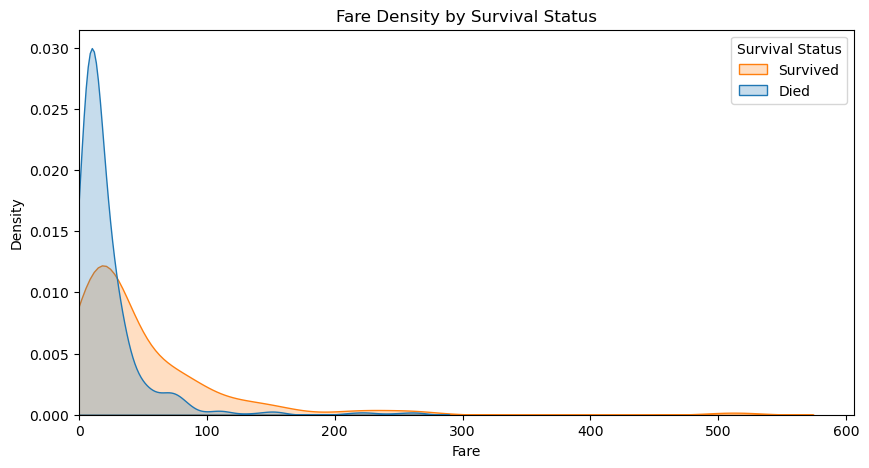

In [441]:
df = pd.DataFrame({'Fare':train_data['Fare'],'Survival':train_data['Survived']})

plt.figure(figsize=(10, 5))
sns.kdeplot(data=df, x='Fare', hue='Survival', common_norm=False, fill=True)
plt.xlim(left=0)
plt.title('Fare Density by Survival Status')
plt.xlabel('Fare')
plt.legend(title="Survival Status", labels=['Survived', 'Died'], loc='upper right')
plt.ylabel('Density')
plt.show()

Fare price has a very strong impact on survival rate as anyone paying more than around 50 has a higher chance of surving than dying.